## Missing Taxa Test

dataset: Cami2
unique species: 
number of reads: 4,310,093

Steps:

1. Randomly generate list of species from Cami2 test dataset (35 of 348 species)
2. Remove those 35 species from the emu database
3. Generate results with exclusionary database for emu, minimap2, Kraken2, Bracken

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## helper functions


# reduce df to only taxa [index] that is present in a col: 'keep_col_name'
def trim_df_col(df, keep_col_name):
    df_results = df.copy()
    df_results = df_results[df_results[keep_col_name].notna()]
    df_results.loc['other']= 100 - df_results.sum()
    return df_results

# reduce df to only taxa [index] with at least one val > thresh 
def trim_df_treshold(df, thresh):
    df_results = df.copy()
    df_results['max'] = df_results.max(axis=1)
    df_results = df_results[df_results['max'] > thresh]
    df_results = df_results.drop(columns=['max'])
    df_results.loc['other']= 100 - df_results.sum()
    return df_results

def trim_df_treshold_diff(df, maxthresh, minthresh):
    df_results = df.copy()
    df_results['max'] = df_results.max(axis=1)
    df_results['min'] = df_results.min(axis=1)
    df_results = df_results[(df_results['min'] < minthresh)|(df_results['max'] > maxthresh)]
    df_results = df_results.drop(columns=['max', 'min'])
    return df_results

def extract_abundance(in_path, rank, in_col, out_col, taxa_col='name', multiplier=1):
    ext = in_path.split(".")[-1]
    if ext == "tsv":
        df_all = pd.read_csv(in_path, sep='\t')
    if ext == "csv":
        df_all = pd.read_csv(in_path)
    df = df_all[[taxa_col, in_col]].groupby(taxa_col).sum().reset_index()
    df = df.rename(columns={in_col:out_col, taxa_col:rank}).dropna()
    df[out_col] = df[out_col] * multiplier
    return df

def extract_abundance_kreport(in_path, rank, out_col):
    kreport_headers = ['clade_abundance', 'clade_counts', 'counts', 'rank', 'tax_id', 'name']
    df = pd.read_csv(in_path, header=None, names=kreport_headers, sep='\t')
    if rank == 'genus':
        df_rank = df[df['rank']=='G'].reset_index(drop=True)
    elif rank == 'species':
        df_rank = df[df['rank']=='S'].reset_index(drop=True)
    elif rank == 'family':
        df_rank = df[df['rank']=='F'].reset_index(drop=True)
    total_counts = sum(df_rank['clade_counts'])
    df_rank['clade_abundance'] = df_rank['clade_counts']/total_counts*100
    df_rank['name_stripped'] = df_rank['name'].apply(lambda x: x.strip())
    df_trimmed = df_rank[['name_stripped', 'clade_abundance']]
    return df_trimmed.rename(columns={'name_stripped':rank, 'clade_abundance':out_col})

def extract_abundance_qiime(path, rank):
    df_results = pd.read_csv(path, sep='\t', skiprows=[0])
    df_results = df_results.rename(columns={df_results.columns[1]:"abundance"})
    df_results[rank] = df_results["#OTU ID"].apply(lambda x: x.split(";")[-1])
    df_results = df_results[df_results[rank].apply(lambda x:x[0]==rank[0])]
    df_results[rank] = df_results[rank].apply(lambda x:x[3:])
    #total = df_results['abundance'].sum()
    df_results['abundance'] = df_results['abundance']*100
    return df_results[[rank,'abundance']].rename(columns={'abundance':'Qiime2'})

def extract_abundance_metamaps(path, rank):
    df_results = pd.read_csv(path, sep='\t')
    df_rank = df_results[df_results['AnalysisLevel']==rank]
    df_rank = df_rank[['Name','EMFrequency']].groupby('Name').sum().reset_index()
    df_rank = df_rank.rename(columns={'Name':rank, 'EMFrequency':'MetaMaps'}).dropna()
    df_rank['MetaMaps'] = df_rank['MetaMaps']*100
    return df_rank

def extract_abundance_nanoclust(nanoclust_path, rank):
    return extract_abundance(nanoclust_path, rank, 'rel_abundance', 'NanoCLUST', taxa_col='taxid', multiplier=100)

def extract_abundance_theoretical(in_path, rank):
    return extract_abundance(in_path, rank, 'abundance', 'theoretical', taxa_col=rank)

def extract_abundance_primary(in_path, rank, out_col):
    return extract_abundance(in_path, rank, 'abundance', out_col, taxa_col=rank, multiplier=100)

def extract_abundance_emu(in_path, rank):
    return extract_abundance(in_path, rank, 'abundance', 'Emu', taxa_col=rank, multiplier=100)

def extract_abundance_bracken(bracken_path, rank):
    return extract_abundance(bracken_path, rank, 'fraction_total_reads', 'Bracken', taxa_col='name', multiplier=100)

def extract_abundance_kraken(kraken_path, rank):
    return extract_abundance_kreport(kraken_path, rank, 'Kraken2')

def extract_abundance_centrifuge(kraken_path, rank):
    return extract_abundance_kreport(kraken_path, rank, 'Centrifuge')


# print L1 and L2 norm for all columns compared to col: 'compare_col_name'
def print_L1_L2(df, compare_col_name):
    df_results = df.copy().fillna(0)
    relative_truth = df_results[compare_col_name]
    df_results = df_results.drop(columns=[compare_col_name])
    df_results = df_results.sub(relative_truth, axis=0).fillna(0)
    df_results_L1 = df_results.applymap(lambda x: abs(x))
    L1 = df_results_L1.sum() * .01
    df_results_L2 = df_results.applymap(lambda x: (x**2))
    L2 = df_results_L2.sum().apply(lambda x: math.sqrt(x)) * .01
    print(f"L1:\n{L1.to_string()}\n")
    print(f"L2:\n{L2.to_string()}\n")
    
# print precision and recall stats for all columns compared to col: 'compare_col_name'
def print_precision_recall(df, compare_col_name):
    df_results = df.copy()
    df_results = df_results.replace(0,np.NaN)
    df_presence = df_results.notnull()
    df_counts = df_presence.sum()
    df_true_positive = df_presence[df_presence[compare_col_name]]
    true_positives = df_true_positive.sum()
    precision = true_positives/df_counts
    sensitivity = true_positives/df_counts[compare_col_name]
    stats = {}
    stats['true_positives'] = df_true_positive.sum()
    stats['false_positives'] = df_counts - true_positives
    stats['precision'] = precision
    stats['recall'] = sensitivity
    stats['f_score'] = 2*precision*sensitivity/(precision+sensitivity)
    display(pd.DataFrame(stats))
    print("\n")
    
def get_unclassified_percent_kreport(in_path, rank):
    total_reads = 4310093
    kreport_headers = ['clade_abundance', 'clade_counts', 'counts', 'rank', 'tax_id', 'name']
    df = pd.read_csv(in_path, header=None, names=kreport_headers, sep='\t')
    if rank == 'genus':
        df_rank = df[df['rank']=='G'].reset_index(drop=True)
    elif rank == 'species':
        df_rank = df[df['rank']=='S'].reset_index(drop=True)
    elif rank == 'family':
        df_rank = df[df['rank']=='F'].reset_index(drop=True)
    total_counts = sum(df_rank['clade_counts'])
    percent_unclassified = (total_reads - total_counts)/total_reads*100
    print(f"Kraken2: {percent_unclassified}%")
    
def get_unclassified_percent_bracken(in_path):
    total_reads = 4310093
    df_all = pd.read_csv(in_path, sep='\t')
    total_counts = sum(df_all['new_est_reads'])
    percent_unclassified = (total_reads - total_counts)/total_reads*100
    print(f"Bracken: {percent_unclassified}%")
    
def get_unclassified_percent_minimap(in_path, rank):
    total_reads = 4310093
    df = pd.read_csv(in_path, sep='\t')
    df_rank = df[df[rank].notna()]
    percent_unclassified = (total_reads - sum(df_rank['count']))/total_reads*100
    print(f"Minimap2: {percent_unclassified}%")
    
def get_unclassified_percent_emu(in_path, assigned_reads, rank):
    total_reads = 4310093
    df = pd.read_csv(in_path, sep='\t')
    df_rank = df[['abundance', rank]]
    total_ab = sum(df_rank.dropna()['abundance'])
    assigned_count = total_ab * assigned_reads
    percent_unclassified = (total_reads - assigned_count)/total_reads*100
    print(f"Emu: {percent_unclassified}%")
    

# Make absolute diff in relative abundance heatmaps for a given sample, sequencing type, and taxonomic rank.
def absolute_diff_heatmap(df, output_name):
    if 'Unnamed: 0' in df.columns:
        df.drop(columns=['Unnamed: 0'], inplace=True)
    if 'unclassified' in df.index:
        df.drop(index=['unclassified'], inplace=True)
    if 'theoretical' in df.columns:
        df.rename(columns={'theoretical': 'truth'}, inplace=True)
    diffs_df = df.copy().fillna(0)
    for col in diffs_df.columns:
        if col != 'truth':
            diffs_df[col] = diffs_df[col] - diffs_df['truth']
    diffs_df.drop(columns=['truth'], inplace=True)

    _, ax = plt.subplots(figsize=(6, 6))
    sns.heatmap(diffs_df, yticklabels=1, xticklabels=1, cmap="RdBu_r", center=0, vmin=-3, vmax=3, square=True)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.7,
                     box.height])
    plt.setp(ax.get_yticklabels(), fontsize=7)
    plt.setp(ax.get_xticklabels(), fontsize=7)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_ylabel('')
    ax.set_xlabel('')
    plt.subplots_adjust(left=0.35)
    plt.savefig(f"./results_heatmap/missing_taxa/{output_name}.png")
    return diffs_df

def top_num_both_dfs(df1, df2, NUM_KEPT=20):
    df1_copy = df1.copy()
    df1_copy['max'] = df1_copy.max(axis=1)
    df2_copy = df2.copy()
    df2_copy['max'] = df2_copy.max(axis=1)
    df1_copy = df1_copy.sort_values(by='max', ascending=False)[:NUM_KEPT + 5]
    df2_copy = df2_copy.sort_values(by='max', ascending=False)[:NUM_KEPT + 5]
    joined_df = df1_copy.join(df2_copy, how='outer', lsuffix='1', rsuffix='2')
    joined_df['overall_max'] = joined_df.max(axis=1)
    joined_df = joined_df.sort_values(by='overall_max', ascending=False)
    all_indices = list(joined_df.index)
    filtered_indices = [index for index in all_indices if index in df1.index and index in df2.index]
    return sorted(filtered_indices[:NUM_KEPT])

def top_num_df(df, NUM_KEPT = 20):
    df_copy = df.copy()
    df_copy['max'] = df_copy.max(axis=1)
    df_copy = df_copy.sort_values(by='max', ascending=False)
    indices = list(df_copy.index)
    return sorted(indices[:NUM_KEPT])

def trim_df_keep_some(df, keep_these):
    df_copy = df.copy()
    df_copy = df_copy.loc[keep_these, :]
    df_copy.loc['other'] = 100 - df_copy.sum()
    return df_copy

def get_taxa_not_in_db(taxa_set, taxonomy_df, rank):
    removed_list = []
    f"{rank} not in database:"
    db_set = set(taxonomy_df[rank])
    for t in taxa_set:
        if t not in db_set:
            removed_list.append(t)
    return removed_list


## EMU DATABASE

In [3]:
## CAMI2 results_quantitative - paths Emudb

# Nanopore truth - primary assignment to restricted db [minimap2]
cami2_theoretical_emu_path = "./results_quantitative/truth/cami2_theoretical.csv"
cami2_removed_emu_path = "results_missing_taxa/cami2_remove_emudb.tsv"

cami2_emudb_emu_path = "./results_missing_taxa/Emu_db/Emu/cami2_rel-abundance.tsv"
cami2_emudb_kraken_path = "./results_missing_taxa/Emu_db/Kraken2/cami2.kreport"
cami2_emudb_bracken_species_path = "./results_missing_taxa/Emu_db/Bracken/cami2_species.tsv"
cami2_emudb_bracken_genus_path = "./results_missing_taxa/Emu_db/Bracken/cami2_genus.tsv"
cami2_emudb_bracken_family_path = "./results_missing_taxa/Emu_db/Bracken/cami2_family.tsv"
cami2_emudb_minimap_path = "./results_missing_taxa/Emu_db/minimap2/cami2_primary_counts.tsv"


In [4]:
## removed family stats
cami2_removed_emu_taxonomy_path = "results_missing_taxa/taxonomy-emu-missing-cami2.tsv"
df_removed_emu = pd.read_csv(cami2_removed_emu_path, sep='\t')
df_emu_removed_taxonomy = pd.read_csv(cami2_removed_emu_taxonomy_path, sep='\t')
emu_removed_family = set(df_removed_emu['family'])

print("Families fully removed from Emu db:")
get_taxa_not_in_db(emu_removed_family, df_emu_removed_taxonomy, 'family')

Families fully removed from Emu db:


[]

L1:
Emu         0.007578
Minimap2    0.016022
Kraken2     0.097357
Bracken     0.956661

L2:
Emu         0.002304
Minimap2    0.004501
Kraken2     0.024522
Bracken     0.410087



true_positives  false_positives  precision    recall   f_score
theoretical              71                0   1.000000  1.000000  1.000000
Emu                      68               11   0.860759  0.957746  0.906667
Minimap2                 70              329   0.175439  0.985915  0.297872
Kraken2                  70              418   0.143443  0.985915  0.250447
Bracken                  60              185   0.244898  0.845070  0.379747



Percent Unclassified:
Emu: 9.238768350727659%
Minimap2: 9.28717779407544%
Kraken2: 14.834807508793894%
Bracken: 66.50039801925388%


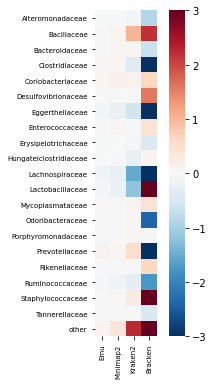

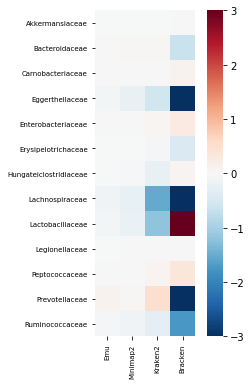

In [5]:
## cami2, Emu DB - family Level

cami2_theoretical_family = extract_abundance_theoretical(cami2_theoretical_emu_path, 'family')
cami2_emudb_emu_family = extract_abundance_emu(cami2_emudb_emu_path,'family')
cami2_emudb_kraken_family = extract_abundance_kraken(cami2_emudb_kraken_path, 'family')
cami2_emudb_bracken_family = extract_abundance_bracken(cami2_emudb_bracken_family_path, 'family')
cami2_emudb_minimap_family = extract_abundance_primary(cami2_emudb_minimap_path, 'family', 'Minimap2')

df_results_cami2_emudb_family = cami2_theoretical_family
df_results_cami2_emudb_family = pd.merge(df_results_cami2_emudb_family, cami2_emudb_emu_family, how='outer', on=['family'])
df_results_cami2_emudb_family = pd.merge(df_results_cami2_emudb_family, cami2_emudb_minimap_family, how='outer', on=['family'])
df_results_cami2_emudb_family = pd.merge(df_results_cami2_emudb_family, cami2_emudb_kraken_family, how='outer', on=['family'])
df_results_cami2_emudb_family = pd.merge(df_results_cami2_emudb_family, cami2_emudb_bracken_family, how='outer', on=['family'])
df_results_cami2_emudb_family = df_results_cami2_emudb_family.set_index("family")
df_results_cami2_emudb_family.to_csv("./results_spreadsheets/missing_taxa/cami2_family_emudb.tsv", sep='\t')

df_results_cami2_emudb_family_top20 = trim_df_keep_some(df_results_cami2_emudb_family, top_num_df(df_results_cami2_emudb_family))
cami2_emudb_family_diff = absolute_diff_heatmap(df_results_cami2_emudb_family_top20, "cami2_family_emudb")

print_L1_L2(df_results_cami2_emudb_family, 'theoretical')
print_precision_recall(df_results_cami2_emudb_family, 'theoretical')

print("Percent Unclassified:")
get_unclassified_percent_emu(cami2_emudb_emu_path, 3944442, 'family')
get_unclassified_percent_minimap(cami2_emudb_minimap_path, 'family')
get_unclassified_percent_kreport(cami2_emudb_kraken_path, 'family')
get_unclassified_percent_bracken(cami2_emudb_bracken_family_path)

emu_removed_family = set(df_removed_emu['family'].dropna())
df_results_removed_family = df_results_cami2_emudb_family.loc[emu_removed_family].sort_values('family')
cami2_emudb_family_removed_diff = absolute_diff_heatmap(df_results_removed_family, "cami2_family_removed_emudb")


In [6]:
## removed genus stats
cami2_removed_emu_taxonomy_path = "results_missing_taxa/taxonomy-emu-missing-cami2.tsv"
df_removed_emu = pd.read_csv(cami2_removed_emu_path, sep='\t')
df_emu_removed_taxonomy = pd.read_csv(cami2_removed_emu_taxonomy_path, sep='\t')
emu_removed_genus = set(df_removed_emu['genus'])

print("Genera fully removed from Emu db:")
get_taxa_not_in_db(emu_removed_genus, df_emu_removed_taxonomy, 'genus')


Genera fully removed from Emu db:


['Gemmiger', 'Sporobacter', 'Acetanaerobacterium', 'Stomatobaculum']

L1:
Emu         0.033252
Minimap2    0.057510
Kraken2     0.156658
Bracken     1.100186

L2:
Emu         0.013306
Minimap2    0.017803
Kraken2     0.030304
Bracken     0.373820



true_positives  false_positives  precision    recall   f_score
theoretical             180                0   1.000000  1.000000  1.000000
Emu                     169               89   0.655039  0.938889  0.771689
Minimap2                175             1548   0.101567  0.972222  0.183920
Kraken2                 172             2148   0.074138  0.955556  0.137600
Bracken                 101              557   0.153495  0.561111  0.241050



Percent Unclassified:
Emu: 9.518194472333928%
Minimap2: 9.558285633279839%
Kraken2: 18.29705298702371%
Bracken: 66.54870324143818%


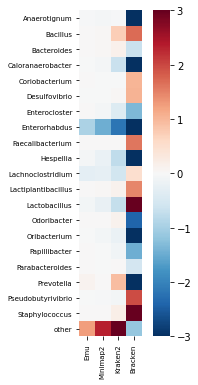

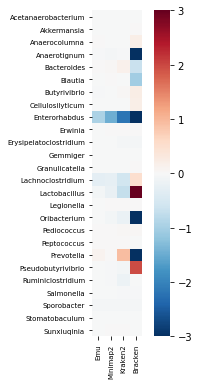

In [7]:
## cami2, Emu DB - genus Level

cami2_theoretical_genus = extract_abundance_theoretical(cami2_theoretical_emu_path, 'genus')
cami2_emudb_emu_genus = extract_abundance_emu(cami2_emudb_emu_path,'genus')
cami2_emudb_kraken_genus = extract_abundance_kraken(cami2_emudb_kraken_path, 'genus')
cami2_emudb_bracken_genus = extract_abundance_bracken(cami2_emudb_bracken_genus_path, 'genus')
cami2_emudb_minimap_genus = extract_abundance_primary(cami2_emudb_minimap_path, 'genus', 'Minimap2')

df_results_cami2_emudb_genus = cami2_theoretical_genus
df_results_cami2_emudb_genus = pd.merge(df_results_cami2_emudb_genus, cami2_emudb_emu_genus, how='outer', on=['genus'])
df_results_cami2_emudb_genus = pd.merge(df_results_cami2_emudb_genus, cami2_emudb_minimap_genus, how='outer', on=['genus'])
df_results_cami2_emudb_genus = pd.merge(df_results_cami2_emudb_genus, cami2_emudb_kraken_genus, how='outer', on=['genus'])
df_results_cami2_emudb_genus = pd.merge(df_results_cami2_emudb_genus, cami2_emudb_bracken_genus, how='outer', on=['genus'])
df_results_cami2_emudb_genus = df_results_cami2_emudb_genus.set_index("genus")
df_results_cami2_emudb_genus.to_csv("./results_spreadsheets/missing_taxa/cami2_genus_emudb.tsv", sep='\t')

df_results_cami2_emudb_genus_top20 = trim_df_keep_some(df_results_cami2_emudb_genus, top_num_df(df_results_cami2_emudb_genus))
cami2_emudb_genus_diff = absolute_diff_heatmap(df_results_cami2_emudb_genus_top20, "cami2_genus_emudb")

print_L1_L2(df_results_cami2_emudb_genus, 'theoretical')
print_precision_recall(df_results_cami2_emudb_genus, 'theoretical')

print("Percent Unclassified:")
get_unclassified_percent_emu(cami2_emudb_emu_path, 3944442, 'genus')
get_unclassified_percent_minimap(cami2_emudb_minimap_path, 'genus')
get_unclassified_percent_kreport(cami2_emudb_kraken_path, 'genus')
get_unclassified_percent_bracken(cami2_emudb_bracken_genus_path)

emu_removed_genus = set(df_removed_emu['genus'])
df_results_removed_genus = df_results_cami2_emudb_genus.loc[emu_removed_genus].sort_values('genus')
cami2_emudb_genus_removed_diff = absolute_diff_heatmap(df_results_removed_genus, "cami2_genus_removed_emudb")


In [8]:
## removed species stats
cami2_removed_emu_taxonomy_path = "results_missing_taxa/taxonomy-emu-missing-cami2.tsv"
df_removed_emu = pd.read_csv(cami2_removed_emu_path, sep='\t', dtype=str)
df_emu_removed_taxonomy = pd.read_csv(cami2_removed_emu_taxonomy_path, sep='\t', dtype=str)
emu_removed_species = set(df_removed_emu['species'])

print("Species fully removed from Emu db:")
get_taxa_not_in_db(emu_removed_species, df_emu_removed_taxonomy, 'species')

Species fully removed from Emu db:


['Sunxiuqinia elliptica',
 'Ruminiclostridium cellobioparum',
 'Sporobacter termitidis',
 'Oribacterium parvum',
 'Lactobacillus pentosus',
 'Stomatobaculum longum',
 'Cellulosilyticum lentocellum',
 'Butyrivibrio crossotus',
 'Akkermansia muciniphila',
 'Lactobacillus mellis',
 'Peptococcus niger',
 'Pediococcus acidilactici',
 '[Clostridium] scindens',
 'Bacteroides luti',
 'Lactobacillus parabuchneri',
 'Erwinia amylovora',
 'Anaerocolumna aminovalerica',
 'Salmonella enterica',
 'Gemmiger formicilis',
 'Anaerotignum propionicum',
 'Prevotella bivia',
 'Lactobacillus parafarraginis',
 'Legionella pneumophila',
 'Prevotella copri',
 'Blautia producta',
 'Lactobacillus jensenii',
 'Prevotella micans',
 'Bacteroides stercoris',
 'Lactobacillus gasseri',
 'Granulicatella adiacens',
 '[Clostridium] saccharogumia',
 'Pseudobutyrivibrio ruminis',
 'Acetanaerobacterium elongatum',
 'Lactobacillus koreensis',
 'Enterorhabdus mucosicola']

L1:
Emu         0.212677
Minimap2    0.296125
Kraken2     0.569506
Bracken     1.466600

L2:
Emu         0.055892
Minimap2    0.055933
Kraken2     0.128205
Bracken     0.329703



true_positives  false_positives  precision    recall   f_score
theoretical             345                0   1.000000  1.000000  1.000000
Emu                     301              319   0.485484  0.872464  0.623834
Minimap2                309             4959   0.058656  0.895652  0.110102
Kraken2                 303             5933   0.048589  0.878261  0.092083
Bracken                 143             1202   0.106320  0.414493  0.169231



Percent Unclassified:
Emu: 8.48359884577419%
Minimap2: 8.485246142020602%
Kraken2: 34.35675285892903%
Bracken: 66.69668148691919%


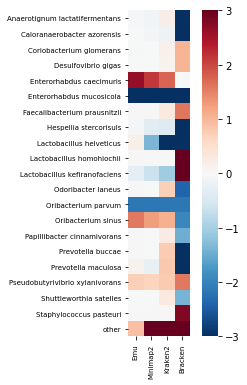

In [9]:
## cami2, Emu DB - species Level

cami2_theoretical_species = extract_abundance_theoretical(cami2_theoretical_emu_path, 'species')
cami2_emudb_emu_species = extract_abundance_emu(cami2_emudb_emu_path,'species')
cami2_emudb_kraken_species = extract_abundance_kraken(cami2_emudb_kraken_path, 'species')
cami2_emudb_bracken_species = extract_abundance_bracken(cami2_emudb_bracken_species_path, 'species')
cami2_emudb_minimap_species = extract_abundance_primary(cami2_emudb_minimap_path, 'species', 'Minimap2')

df_results_cami2_emudb_species = cami2_theoretical_species
df_results_cami2_emudb_species = pd.merge(df_results_cami2_emudb_species, cami2_emudb_emu_species, how='outer', on=['species'])
df_results_cami2_emudb_species = pd.merge(df_results_cami2_emudb_species, cami2_emudb_minimap_species, how='outer', on=['species'])
df_results_cami2_emudb_species = pd.merge(df_results_cami2_emudb_species, cami2_emudb_kraken_species, how='outer', on=['species'])
df_results_cami2_emudb_species = pd.merge(df_results_cami2_emudb_species, cami2_emudb_bracken_species, how='outer', on=['species'])
df_results_cami2_emudb_species = df_results_cami2_emudb_species.set_index("species")
df_results_cami2_emudb_species.to_csv("./results_spreadsheets/missing_taxa/cami2_species_emudb.tsv", sep='\t')

df_results_cami2_emudb_species_top20 = trim_df_keep_some(df_results_cami2_emudb_species, top_num_df(df_results_cami2_emudb_species))
cami2_emudb_species_diff = absolute_diff_heatmap(df_results_cami2_emudb_species_top20, "cami2_species_emudb")

print_L1_L2(df_results_cami2_emudb_species, 'theoretical')
print_precision_recall(df_results_cami2_emudb_species, 'theoretical')

print("Percent Unclassified:")
get_unclassified_percent_emu(cami2_emudb_emu_path, 3944442, 'species')
get_unclassified_percent_minimap(cami2_emudb_minimap_path, 'species')
get_unclassified_percent_kreport(cami2_emudb_kraken_path, 'species')
get_unclassified_percent_bracken(cami2_emudb_bracken_species_path)

## sanity check: df_results_removed_species should be all Nan
df_removed_emu = pd.read_csv(cami2_removed_emu_path, sep='\t')
emu_removed_species = df_removed_emu['species']
df_results_removed_species = df_results_cami2_emudb_species.loc[emu_removed_species]




## RDP

In [10]:
## CAMI2 results_quantitative - paths RDP
cami2_theoretical_RDP_path = "./results_quantitative/truth/cami2_theoretical_RDP.csv"
cami2_removed_rdp_path = "results_missing_taxa/cami2_remove_rdp.tsv"

# Nanopore truth - primary assignment to restricted db [minimap2]
cami2_rdp_emu_path = "./results_missing_taxa/RDP/Emu/cami2_rel-abundance.tsv"
cami2_rdp_kraken_path = "./results_missing_taxa/RDP/Kraken2/cami2.kreport"
cami2_rdp_bracken_species_path = "./results_missing_taxa/RDP/Bracken/cami2_species.tsv"
cami2_rdp_bracken_genus_path = "./results_missing_taxa/RDP/Bracken/cami2_genus.tsv"
cami2_rdp_bracken_family_path = "./results_missing_taxa/RDP/Bracken/cami2_family.tsv"
cami2_rdp_minimap_path = "./results_missing_taxa/RDP/minimap2/cami2_primary_counts.tsv"


In [11]:
## removed family stats
cami2_removed_rdp_taxonomy_path = "results_missing_taxa/taxonomy-rdp-missing-cami2.tsv"
df_removed_rdp = pd.read_csv(cami2_removed_rdp_path, sep='\t', dtype=str)
df_rdp_removed_taxonomy = pd.read_csv(cami2_removed_rdp_taxonomy_path, sep='\t', dtype=str)
rdp_removed_family = set(df_removed_rdp['family'])

print("Families fully removed from rdp db:")
get_taxa_not_in_db(rdp_removed_family, df_rdp_removed_taxonomy, 'family')


Families fully removed from rdp db:


[]

L1:
Emu         0.137713
Minimap2    0.150688
Kraken2     0.449498
Bracken     0.870946

L2:
Emu         0.056610
Minimap2    0.056559
Kraken2     0.125356
Bracken     0.242575



true_positives  false_positives  precision    recall   f_score
theoretical              72                0   1.000000  1.000000  1.000000
Emu                      65               16   0.802469  0.902778  0.849673
Minimap2                 71              273   0.206395  0.986111  0.341346
Kraken2                  71              466   0.132216  0.986111  0.233169
Bracken                  60              210   0.222222  0.833333  0.350877



Percent Unclassified:
Emu: 19.516190519722546%
Minimap2: 18.973047681337736%
Kraken2: 37.9565823753687%
Bracken: 33.06058593167247%


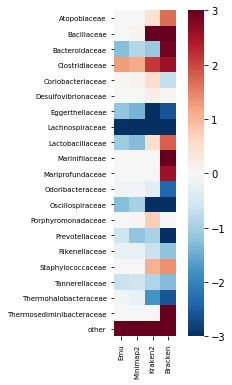

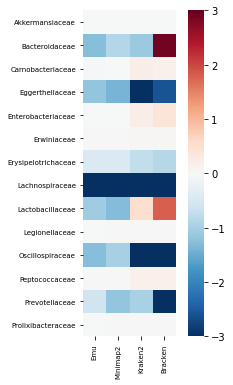

In [12]:
## cami2, RDP - family Level

cami2_theoretical_family = extract_abundance_theoretical(cami2_theoretical_RDP_path, 'family')
cami2_rdp_emu_family = extract_abundance_emu(cami2_rdp_emu_path,'family')
cami2_rdp_kraken_family = extract_abundance_kraken(cami2_rdp_kraken_path, 'family')
cami2_rdp_bracken_family = extract_abundance_bracken(cami2_rdp_bracken_family_path, 'family')
cami2_rdp_minimap_family = extract_abundance_primary(cami2_rdp_minimap_path, 'family', 'Minimap2')

df_results_cami2_rdp_family = cami2_theoretical_family
df_results_cami2_rdp_family = pd.merge(df_results_cami2_rdp_family, cami2_rdp_emu_family, how='outer', on=['family'])
df_results_cami2_rdp_family = pd.merge(df_results_cami2_rdp_family, cami2_rdp_minimap_family, how='outer', on=['family'])
df_results_cami2_rdp_family = pd.merge(df_results_cami2_rdp_family, cami2_rdp_kraken_family, how='outer', on=['family'])
df_results_cami2_rdp_family = pd.merge(df_results_cami2_rdp_family, cami2_rdp_bracken_family, how='outer', on=['family'])
df_results_cami2_rdp_family = df_results_cami2_rdp_family.set_index("family")
df_results_cami2_rdp_family.to_csv("./results_spreadsheets/missing_taxa/cami2_family_rdp.tsv", sep='\t')

df_results_cami2_rdp_family_top20 = trim_df_keep_some(df_results_cami2_rdp_family, top_num_df(df_results_cami2_rdp_family))
cami2_rdp_family_diff = absolute_diff_heatmap(df_results_cami2_rdp_family_top20, "cami2_family_rdp")

print_L1_L2(df_results_cami2_rdp_family, 'theoretical')
print_precision_recall(df_results_cami2_rdp_family, 'theoretical')

print("Percent Unclassified:")
get_unclassified_percent_emu(cami2_rdp_emu_path, 3896929, 'family')
get_unclassified_percent_minimap(cami2_rdp_minimap_path, 'family')
get_unclassified_percent_kreport(cami2_rdp_kraken_path, 'family')
get_unclassified_percent_bracken(cami2_rdp_bracken_family_path)

rdp_removed_family = set(df_removed_rdp['family'].dropna())
df_results_removed_family = df_results_cami2_rdp_family.loc[rdp_removed_family].sort_values('family')
cami2_rdp_family_removed_diff = absolute_diff_heatmap(df_results_removed_family, "cami2_family_removed_rdp")


In [13]:
## removed genus stats
cami2_removed_rdp_taxonomy_path = "results_missing_taxa/taxonomy-rdp-missing-cami2.tsv"
df_removed_rdp = pd.read_csv(cami2_removed_rdp_path, sep='\t', dtype=str)
df_rdp_removed_taxonomy = pd.read_csv(cami2_removed_rdp_taxonomy_path, sep='\t', dtype=str)
rdp_removed_genus = set(df_removed_rdp['genus'])

print("Genera fully removed from rdp db:")
get_taxa_not_in_db(rdp_removed_genus, df_rdp_removed_taxonomy, 'genus')


Genera fully removed from rdp db:


['Gemmiger', 'Stomatobaculum']

L1:
Emu         0.176037
Minimap2    0.192151
Kraken2     0.626946
Bracken     1.032980

L2:
Emu         0.032919
Minimap2    0.037207
Kraken2     0.095584
Bracken     0.159706



true_positives  false_positives  precision    recall   f_score
theoretical             190                0   1.000000  1.000000  1.000000
Emu                     159               47   0.771845  0.836842  0.803030
Minimap2                182              992   0.155026  0.957895  0.266862
Kraken2                 174             2058   0.077957  0.915789  0.143683
Bracken                 108              541   0.166410  0.568421  0.257449



Percent Unclassified:
Emu: 21.99725184895517%
Minimap2: 22.237408798371636%
Kraken2: 47.15807756352357%
Bracken: 33.481342513955035%


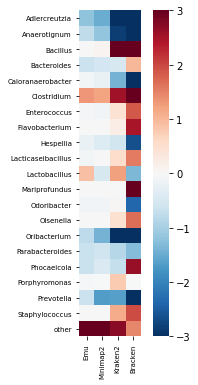

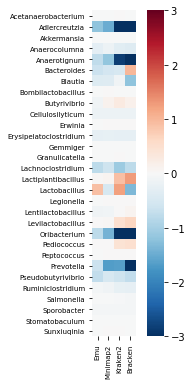

In [14]:
## cami2, RDP - genus Level

cami2_theoretical_genus = extract_abundance_theoretical(cami2_theoretical_RDP_path, 'genus')
cami2_rdp_emu_genus = extract_abundance_emu(cami2_rdp_emu_path,'genus')
cami2_rdp_kraken_genus = extract_abundance_kraken(cami2_rdp_kraken_path, 'genus')
cami2_rdp_bracken_genus = extract_abundance_bracken(cami2_rdp_bracken_genus_path, 'genus')
cami2_rdp_minimap_genus = extract_abundance_primary(cami2_rdp_minimap_path, 'genus', 'Minimap2')

df_results_cami2_rdp_genus = cami2_theoretical_genus
df_results_cami2_rdp_genus = pd.merge(df_results_cami2_rdp_genus, cami2_rdp_emu_genus, how='outer', on=['genus'])
df_results_cami2_rdp_genus = pd.merge(df_results_cami2_rdp_genus, cami2_rdp_minimap_genus, how='outer', on=['genus'])
df_results_cami2_rdp_genus = pd.merge(df_results_cami2_rdp_genus, cami2_rdp_kraken_genus, how='outer', on=['genus'])
df_results_cami2_rdp_genus = pd.merge(df_results_cami2_rdp_genus, cami2_rdp_bracken_genus, how='outer', on=['genus'])
df_results_cami2_rdp_genus = df_results_cami2_rdp_genus.set_index("genus")
df_results_cami2_rdp_genus.to_csv("./results_spreadsheets/missing_taxa/cami2_genus_rdp.tsv", sep='\t')

df_results_cami2_rdp_genus_top20 = trim_df_keep_some(df_results_cami2_rdp_genus, top_num_df(df_results_cami2_rdp_genus))
cami2_rdp_genus_diff = absolute_diff_heatmap(df_results_cami2_rdp_genus_top20, "cami2_genus_rdp")

print_L1_L2(df_results_cami2_rdp_genus, 'theoretical')
print_precision_recall(df_results_cami2_rdp_genus, 'theoretical')

print("Percent Unclassified:")
get_unclassified_percent_emu(cami2_rdp_emu_path, 3896929, 'genus')
get_unclassified_percent_minimap(cami2_rdp_minimap_path, 'genus')
get_unclassified_percent_kreport(cami2_rdp_kraken_path, 'genus')
get_unclassified_percent_bracken(cami2_rdp_bracken_genus_path)

rdp_removed_genus = set(df_removed_rdp['genus'])
df_results_removed_genus = df_results_cami2_rdp_genus.loc[rdp_removed_genus].sort_values('genus')
cami2_rdp_genus_removed_diff = absolute_diff_heatmap(df_results_removed_genus, "cami2_genus_removed_rdp")


In [15]:
## removed species stats
cami2_removed_rdp_taxonomy_path = "results_missing_taxa/taxonomy-rdp-missing-cami2.tsv"
df_removed_rdp = pd.read_csv(cami2_removed_rdp_path, sep='\t', dtype=str)
df_rdp_removed_taxonomy = pd.read_csv(cami2_removed_rdp_taxonomy_path, sep='\t', dtype=str)
rdp_removed_species = set(df_removed_rdp['species'])

print("Species fully removed from rdp:")
get_taxa_not_in_db(rdp_removed_species, df_rdp_removed_taxonomy, 'species')


Species fully removed from rdp:


['Levilactobacillus koreensis',
 'Sunxiuqinia elliptica',
 'Adlercreutzia mucosicola',
 'Ruminiclostridium cellobioparum',
 'Sporobacter termitidis',
 'Lentilactobacillus parabuchneri',
 'Oribacterium parvum',
 'Stomatobaculum longum',
 'Cellulosilyticum lentocellum',
 'Butyrivibrio crossotus',
 'Akkermansia muciniphila',
 'Bombilactobacillus mellis',
 'Lentilactobacillus parafarraginis',
 'Peptococcus niger',
 'Pediococcus acidilactici',
 '[Clostridium] scindens',
 'Bacteroides luti',
 'Erwinia amylovora',
 'Anaerocolumna aminovalerica',
 'Salmonella enterica',
 'Gemmiger formicilis',
 'Anaerotignum propionicum',
 'Lactiplantibacillus pentosus',
 'Prevotella bivia',
 'Legionella pneumophila',
 'Prevotella copri',
 'Blautia producta',
 'Lactobacillus jensenii',
 'Prevotella micans',
 'Bacteroides stercoris',
 'Lactobacillus gasseri',
 'Granulicatella adiacens',
 '[Clostridium] saccharogumia',
 'Pseudobutyrivibrio ruminis',
 'Acetanaerobacterium elongatum']

L1:
Emu         0.575504
Minimap2    0.701819
Kraken2     1.555027
Bracken     1.707141

L2:
Emu         0.099463
Minimap2    0.086284
Kraken2     0.204202
Bracken     0.222621



true_positives  false_positives  precision    recall   f_score
theoretical             345                0   1.000000  1.000000  1.000000
Emu                     261              457   0.363510  0.756522  0.491063
Minimap2                298            12713   0.022904  0.863768  0.044624
Kraken2                 266            30806   0.008561  0.771014  0.016934
Bracken                 136             1803   0.070139  0.394203  0.119089



Percent Unclassified:
Emu: 9.585964850408194%
Minimap2: 9.587612146652056%
Kraken2: 42.4011268434347%
Bracken: 34.192603268653365%


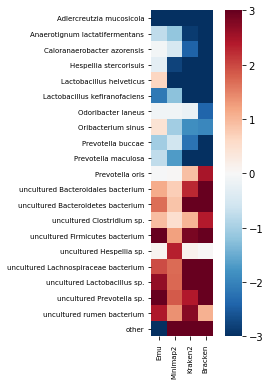

In [16]:
## cami2, RDP - species Level

cami2_theoretical_species = extract_abundance_theoretical(cami2_theoretical_RDP_path, 'species')
cami2_rdp_emu_species = extract_abundance_emu(cami2_rdp_emu_path,'species')
cami2_rdp_kraken_species = extract_abundance_kraken(cami2_rdp_kraken_path, 'species')
cami2_rdp_bracken_species = extract_abundance_bracken(cami2_rdp_bracken_species_path, 'species')
cami2_rdp_minimap_species = extract_abundance_primary(cami2_rdp_minimap_path, 'species', 'Minimap2')

df_results_cami2_rdp_species = cami2_theoretical_species
df_results_cami2_rdp_species = pd.merge(df_results_cami2_rdp_species, cami2_rdp_emu_species, how='outer', on=['species'])
df_results_cami2_rdp_species = pd.merge(df_results_cami2_rdp_species, cami2_rdp_minimap_species, how='outer', on=['species'])
df_results_cami2_rdp_species = pd.merge(df_results_cami2_rdp_species, cami2_rdp_kraken_species, how='outer', on=['species'])
df_results_cami2_rdp_species = pd.merge(df_results_cami2_rdp_species, cami2_rdp_bracken_species, how='outer', on=['species'])
df_results_cami2_rdp_species = df_results_cami2_rdp_species.set_index("species")
df_results_cami2_rdp_species.to_csv("./results_spreadsheets/missing_taxa/cami2_species_rdp.tsv", sep='\t')

df_results_cami2_rdp_species_top20 = trim_df_keep_some(df_results_cami2_rdp_species, top_num_df(df_results_cami2_rdp_species))
cami2_rdp_species_diff = absolute_diff_heatmap(df_results_cami2_rdp_species_top20, "cami2_species_rdp")

print_L1_L2(df_results_cami2_rdp_species, 'theoretical')
print_precision_recall(df_results_cami2_rdp_species, 'theoretical')

print("Percent Unclassified:")
get_unclassified_percent_emu(cami2_rdp_emu_path, 3896929, 'species')
get_unclassified_percent_minimap(cami2_rdp_minimap_path, 'species')
get_unclassified_percent_kreport(cami2_rdp_kraken_path, 'species')
get_unclassified_percent_bracken(cami2_rdp_bracken_species_path)

## sanity check: df_results_removed_species should be all Nan
df_removed_rdp = pd.read_csv(cami2_removed_rdp_path, sep='\t')
rdp_removed_species = df_removed_rdp['species']
df_results_removed_species = df_results_cami2_rdp_species.loc[rdp_removed_species]



## EXTRA SCRIPTS

In [17]:
def get_name(tid, names_dict):
    return names_dict[str(tid)]

def get_parent_id(tid, nodes_dict):
    return nodes_dict[str(tid)]['parent_tax_id']

def get_rank(tid, nodes_dict):
    return nodes_dict[str(tid)]['rank']

def get_genus_name(tid, names_dict, nodes_dict):
    rank = get_rank(tid, nodes_dict)
    while rank != "no rank":
        if rank == "genus":
            return get_name(tid, names_dict)
        tid = get_parent_id(tid, nodes_dict)
        rank = get_rank(tid, nodes_dict)
    return "None"

def get_rank_name(tid, rank, names_dict, nodes_dict):
    rank = get_rank(tid, nodes_dict)
    while rank != "no rank":
        if rank == rank:
            return get_name(tid, names_dict)
        id = int(get_parent_id(tid, nodes_dict))
        rank = get_rank(tid, nodes_dict)
    return "-"


In [18]:
#emu_names_path = "/Users/kcurry/emu_dir/emu-databases/v1/db_emu/names_df.tsv"
#emu_names_df = pd.read_csv(emu_names_path, sep='\t', dtype=str)
#emu_names_dict = dict(zip(emu_names_df['tax_id'], emu_names_df['name_txt']))
#emu_nodes_path = "/Users/kcurry/emu_dir/emu-databases/v1/db_emu/nodes_df.tsv"
#emu_nodes_df = pd.read_csv(emu_nodes_path, sep='\t', dtype=str).set_index('tax_id')
#emu_nodes_dict = emu_nodes_df.to_dict('index')
#rdp_names_path = "/Users/kcurry/emu_dir/emu/db_rdp/emu-rdp-v1/names_df.tsv"
#rdp_names_df = pd.read_csv(rdp_names_path, sep='\t', dtype=str)
#rdp_names_dict = dict(zip(rdp_names_df['tax_id'], rdp_names_df['name_txt']))
#rdp_nodes_path = "/Users/kcurry/emu_dir/emu/db_rdp/emu-rdp-v1/nodes_df.tsv"
#rdp_nodes_df = pd.read_csv(rdp_nodes_path, sep='\t', dtype=str).set_index('tax_id')
#rdp_nodes_dict = rdp_nodes_df.to_dict('index')
#cami_metadata_path = "/Users/kcurry/emu_dir/emu-benchmark/results_quantitative/truth/cami2_metadata.tsv"
#cami_metadata_df = pd.read_csv(cami_metadata_path, sep='\t', dtype=str)


In [19]:
## run once to generate random list of 35 species to remove
#cami_reduced = cami_df[['scientific name - species', 'taxid', 'trunc_abundance']]
#cami_reduced = cami_reduced.groupby('taxid').sum()
#species_to_remove = cami_reduced.sample(n=35)
#sum(species_to_remove['trunc_abundance'])

In [20]:
## Which removed species/genus were not found in emu full db results?
#df_results = pd.read_csv(cami2_emudb_emu_path, sep='\t')
#df_results_full = pd.read_csv("/Users/kcurry/emu_dir/emu-benchmark/results_quantitative/Emu_v2.0.1/cami2_rel-abundance.tsv", sep='\t')
#df = pd.read_csv("/Users/kcurry/emu_dir/emu-benchmark/results_missing_taxa/cami2_remove.tsv", sep='\t')

## Species not in full db results
#for s in df['species']:
#    if s not in set(df_results_full['species']):
#        print(s)
        

#for g in df['genus']:
#    if g not in set(df_results_full['genus']):
#        print(g)


In [21]:
#cami2_theoretical_emu_path = "./results_quantitative/truth/cami2_metadata.tsv"
#emu_taxonomy_path = "/Users/kcurry/emu_dir/emu-databases/emu/taxonomy-emu.tsv"
#rdp_taxonomy_path = "/Users/kcurry/emu_dir/emu-databases/rdp/taxonomy-rdp.tsv"
#emu_tax = pd.read_csv(emu_taxonomy_path, sep='\t', dtype=str).set_index('tax_id')
#rdp_tax = pd.read_csv(rdp_taxonomy_path, sep='\t', dtype=str).set_index('tax_id')

#metadata = pd.read_csv(cami2_theoretical_emu_path, sep='\t')
#df_emu = metadata[['trunc_abundance', 'database_id']]
#df_emu['taxid'] = df_emu['database_id'].apply(lambda x: x.split(":")[0])
#df_emu = df_emu.set_index('taxid')
#df_out = df_emu.join(emu_tax, how='left')
#df_out.to_csv('~/Desktop/tmp.tsv', sep='\t')

#metadata = pd.read_csv(cami2_theoretical_emu_path, sep='\t')
#df_rdp = metadata[['trunc_abundance', 'database_id']]
#df_rdp['taxid'] = df_rdp['database_id'].apply(lambda x: x.split(":")[0])
#df_rdp = df_rdp.set_index('taxid')
#df_out = df_rdp.join(rdp_tax, how='left')
#df_out.to_csv('~/Desktop/tmp.tsv', sep='\t')